# Import Libraries

In [2]:
!pip install pingouin

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.4/204.4 kB 6.9 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
#from adjustText import adjust_text
from sklearn.preprocessing import LabelEncoder
from matplotlib import cm, colors
from scipy.stats import pearsonr

from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import statsmodels.api as sm
from scipy import stats
import pingouin as pg

In [4]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!pip install pyfonts
from pyfonts import load_google_font
import matplotlib as mpl
import matplotlib.font_manager as fm

# Load and register font only once
font_prop = load_google_font("Arimo")
fm.fontManager.addfont(font_prop.get_file())
mpl.rcParams['font.family'] = font_prop.get_name()

# Load data

In [6]:
datapath = '/content/drive/MyDrive/Help_Decision_Modeling/Github/' # change it to your own directory
# load data
Task1_filtered = pd.read_csv(datapath+'data/Task1_Final.csv')
trait_all = pd.read_csv(datapath+'data/Trait_Final.csv')
Task1_filtered['prop_Help'] = (Task1_filtered[[f'Q{i}' for i in range(1,101)]] > 0).sum(axis=1)/Task1_filtered['ValidS']
scenario_summary = pd.read_csv(datapath+'data/Task1_scenario_summary.csv',index_col=0)
Task2_ratings = pd.read_csv(datapath+'data/Task2_scenario_ratings_AC_Var_Mean.csv',index_col=0)
WTH_mot = pd.read_csv(datapath+'data/WTH_motivation_decomposition.csv',index_col=0)


In [7]:
# load modeling output
# check the prediction accuracy of scenarios
model_fit_m2 = pd.read_csv(datapath+'output/Model/VBD_M2/model_fits.csv')
pred_allsub_df_m2 = pd.read_csv(datapath+'output/Model/VBD_M2/LOO_pred.csv')
# parameter recovery
param_rec_df = pd.read_csv(datapath+'output/Model/VBD_M2/param_recovery_sampledparam.csv')

In [8]:
trait_merge = trait_all.merge(Task1_filtered[['Mean','PROLIFIC_PID']],on = 'PROLIFIC_PID',how = 'left')
trait_merge = trait_merge.merge(model_fit_m2,left_on = 'PROLIFIC_PID',right_on = 'ID',how = 'left')

In [9]:
# load 3 space characterizations
data_3spec = pd.read_csv(datapath+'output/data_three_spaces.csv',index_col = 0) # this spreadsheet is updated with the finalized scenario descriptions
label_encoder = LabelEncoder()
label_encoded = label_encoder.fit_transform(data_3spec['Semantic_label'])
data_3spec['label_numeric'] = label_encoded

# Figure 2: Rating overview

## 2a: mean WTH ratings in descending order

/tmp/ipython-input-965260278.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=sorted_rating, x=sorted_rating.index, y="mean",palette=bar_colors)
/tmp/ipython-input-965260278.py:18: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  ax = sns.barplot(data=sorted_rating, x=sorted_rating.index, y="mean",palette=bar_colors)


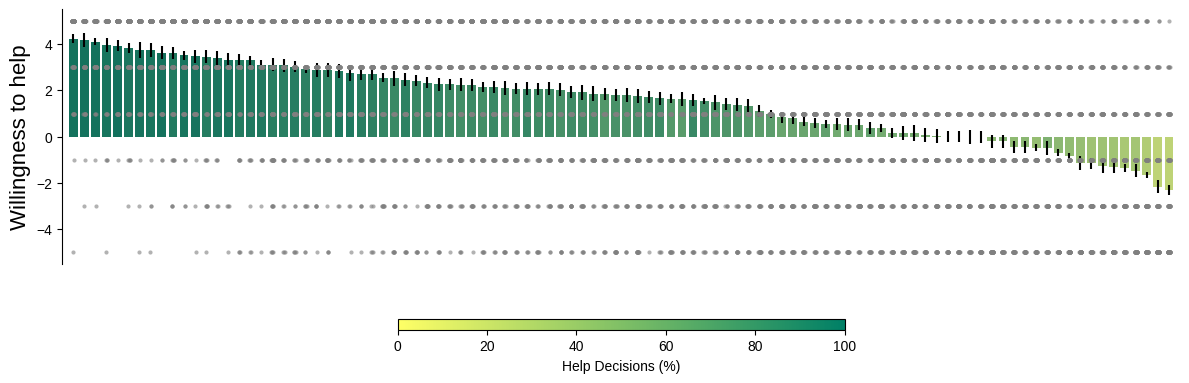

In [ ]:
# prepare the dataframe for stripplot
q_columns = [col for col in Task1_filtered.columns if col.startswith('Q')]
df_q = Task1_filtered[q_columns]
mean_values = df_q.mean().sort_values(ascending=False)
sorted_columns = mean_values.index.tolist()
df_melted = df_q[sorted_columns].melt(var_name='Question', value_name='Value')

# Rank scenarios
sorted_rating = scenario_summary.sort_values(by='mean',ascending=False)

# set the colors
norm = colors.Normalize(vmin=0, vmax=100)
cmap = cm.summer_r  # Choose the color map
bar_colors = cmap(sorted_rating['help_prop'])

# make plot
plt.figure(figsize=(12, 4))
ax = sns.barplot(data=sorted_rating, x=sorted_rating.index, y="mean",palette=bar_colors)
ax.errorbar(range(100), sorted_rating['mean'], sorted_rating['SD']/np.sqrt(scenario_summary['n']),lw=1.5, fmt = 'none',color="black")
sns.stripplot(data=df_melted, x='Question', y='Value', order=sorted_columns, color = 'gray',size=3,alpha=0.6,ax=ax)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

cbar = ax.figure.colorbar(sm, ax=ax, orientation='horizontal', pad=0.15, aspect=40, shrink=0.4)
cbar.set_label('Help Decisions (%)')
cbar.ax.yaxis.set_label_position('right')
ax.set_ylabel('Willingness to help', size=16)
ax.set_xlabel('')
ax.set_xticks([])

plt.ylim(-5.5,5.5)
ax.set_xlim([-1,100])

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)

plt.tight_layout()
plt.savefig(datapath+"/output/Figures/Fig_2/Fig_2a.svg", dpi=300, format='svg', bbox_inches='tight')

plt.show()

## 2b: distribution of WTH

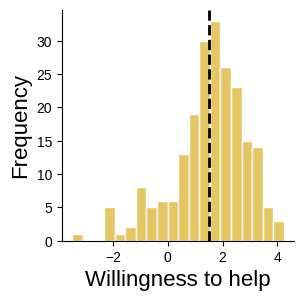

Mean = 1.516531337734727
SD = 1.3526321239621988


In [ ]:
# Average willingness rating
plt.figure(figsize=(3,3))

plt.hist(Task1_filtered['Mean'],bins=20,facecolor = '#e6c563',edgecolor = 'white')
plt.xlabel('Willingness to help',size=16)
plt.axvline(Task1_filtered['Mean'].mean(),color='black',ls='--',lw=2)
plt.ylabel('Frequency', size=16)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.savefig(datapath+"/output/Figures/Fig_2/Fig_2b1.svg", dpi=300, format='svg', bbox_inches='tight')
plt.show()
print(f"Mean = {Task1_filtered['Mean'].mean()}")
print(f"SD = {Task1_filtered['Mean'].std()}")

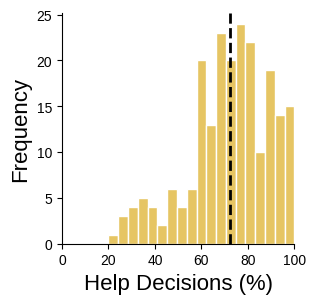

Mean = 0.7219078801584112
SD = 0.17558900358478838


In [ ]:
# Binarized helping propensity
plt.figure(figsize=(3,3))

plt.hist(Task1_filtered['prop_Help']*100,bins=19,facecolor = '#e6c563',edgecolor = 'white')
plt.xlabel('Help Decisions (%)',size=16)
plt.axvline(Task1_filtered['prop_Help'].mean()*100,color='black',ls='--',lw=2)
plt.ylabel('Frequency', size=16)
plt.xlim([0,100])

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.savefig(datapath+"/output/Figures/Fig_2/Fig_2b2.svg", dpi=300, format='svg', bbox_inches='tight')
plt.show()
print(f"Mean = {Task1_filtered['prop_Help'].mean()}")
print(f"SD = {Task1_filtered['prop_Help'].std()}")

## 2c: heatmap of scenario ratings

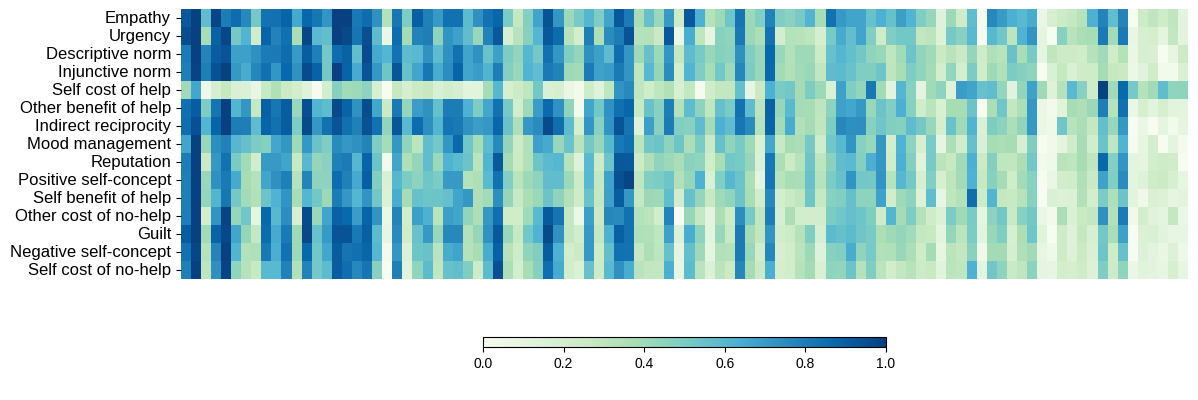

In [ ]:
rating_df = Task2_ratings.drop(columns = 'Other').astype('float')
# sort by the mean WTH rating
rating_df['WTH'] = scenario_summary['mean'].values
sorted_task2_ratings = rating_df.sort_values(by='WTH',ascending=False)
sorted_task2_ratings = sorted_task2_ratings.drop(columns = 'WTH')
rating_df_normalized = (sorted_task2_ratings - sorted_task2_ratings.min()) / (sorted_task2_ratings.max() - sorted_task2_ratings.min())

# plot
fig,ax = plt.subplots(figsize = (13,5))
sns.heatmap(rating_df_normalized.T, cmap = 'GnBu',annot=False, cbar=False, cbar_kws={'orientation':'horizontal','shrink':0.5}, ax= ax)
ax.set_xticks([])
ax.set_yticklabels(['Empathy','Urgency','Descriptive norm','Injunctive norm','Self cost of help','Other benefit of help','Indirect reciprocity',
               'Mood management','Reputation','Positive self-concept','Self benefit of help','Other cost of no-help','Guilt','Negative self-concept','Self cost of no-help'],fontsize=12)

# set the colors
norm = colors.Normalize(vmin=0, vmax=1)
cmap = cm.GnBu  # Choose the color map
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = ax.figure.colorbar(sm, ax=ax,orientation='horizontal', pad=0.15, aspect=40, shrink=0.4)
cbar.set_label(' ')

plt.savefig(datapath+"/output/Figures/Fig_2/Fig_2c.svg", dpi=300, format='svg', bbox_inches='tight')
plt.show()

# Supp Figure 3: Factor Analysis

Fig S3 b-e are produced in notebook Factor_Analysis.ipynb with R code

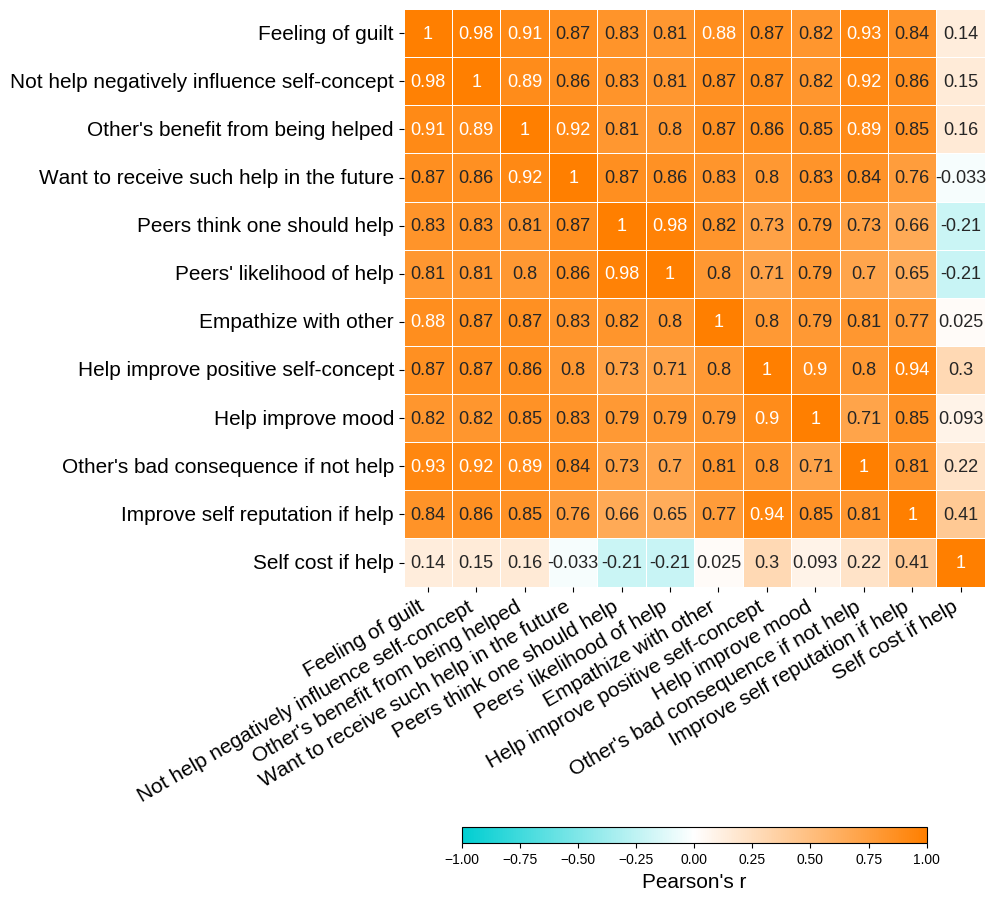

In [ ]:
import matplotlib.colors as mcolors

varlist = ['Guilt','Neg_SelfConcept','Benefit_O_H','Reciprocity','Inj_Norm','Des_Norm',
            'Empathy','Pos_SelfConcept','Mood','Cost_O_NH','Reputation','Cost_S_H']
labellist = ['Feeling of guilt','Not help negatively influence self-concept','Other\'s benefit from being helped',
           'Want to receive such help in the future','Peers think one should help','Peers\' likelihood of help',
            'Empathize with other','Help improve positive self-concept','Help improve mood',
           'Other\'s bad consequence if not help','Improve self reputation if help','Self cost if help']
plt.figure(figsize=(7.5,12.5))
cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", ["#00CED1", "white", "#FF7F00"])
ax = sns.heatmap(rating_df_normalized[varlist].corr(), cmap=cmap,vmin=-1,vmax=1,
                 annot=True,cbar=False,linecolor='white',lw=0.5,annot_kws={"fontsize": 13})
ax.set_xticklabels(labellist, rotation=30, ha="right", fontsize=15)  # Rotate if needed
ax.set_yticklabels(labellist, rotation=0, fontsize=15)

# set the colors
norm = colors.Normalize(vmin=-1, vmax=1)
#cmap = cm.coolwarm  # Choose the color map
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = ax.figure.colorbar(sm, ax=plt.gca(),orientation='horizontal', pad=0.25, aspect=30, shrink=0.8)
cbar.set_label('Pearson\'s r',fontsize=15)

plt.savefig(datapath+"/output/Figures/Fig_S3/Fig_S3a.svg", dpi=300, format='svg', bbox_inches='tight')
plt.show()



# Figure 3. Model Helping Decisions

## 3a: the softmax

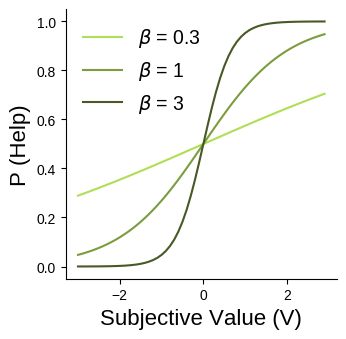

In [ ]:
x = np.arange(-3,3,0.1)
beta_list = [0.3, 1, 3]
color_list  = ['#b0de54','#7c9c3e','#485925']
plt.figure(figsize=(3.5,3.5))
for beta,col in zip(beta_list,color_list):
    y = 1/(1+np.exp(-beta*x))
    plt.plot(x,y, label = r'$\beta$ = '+ f'{beta}',color=col )
plt.xlabel('Subjective Value (V)',size=16)
plt.ylabel('P (Help)',size=16)
plt.legend(frameon=False, fontsize=14)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.savefig(datapath+"output/Figures/Fig_3/Fig_3a.svg", dpi=300, format='svg', bbox_inches='tight')
plt.show()

## 3b: model comparison

In [ ]:
def extract_diagnostics(model_list,metric,n_param):
    summary_all = None
    for mname,k in zip(model_list,n_param):
        model_m = pd.read_csv(datapath+'output/Model/'+mname+'/model_fits.csv')
        # revise AIC, BIC
   #     model_m['AIC'] = 2*k + 2*model_m['neg_llh']
   #     model_m['BIC'] = np.log(50)*k + 2*model_m['neg_llh']
        model_m[mname] = model_m[metric]
        if summary_all is None:
            summary_all = model_m[['ID',mname]]
        else:
            summary_all = summary_all.merge(model_m[['ID',mname]],on = 'ID')
    return summary_all

/tmp/ipython-input-612840967.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(model_names, rotation=30, ha='right', size = 15)


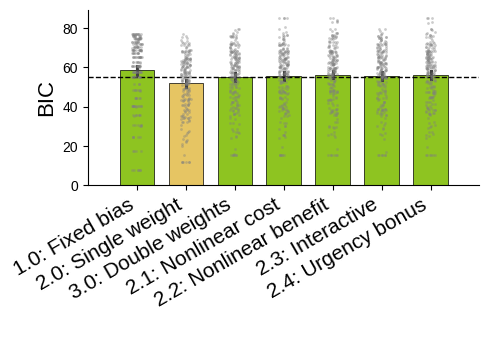

In [ ]:
model_list = ['VBD_M1','VBD_M2','VBD_M3','VBD_M2_1','VBD_M2_2','VBD_M2_3','VBD_M2_4']
n_param = [2, 3, 4, 4, 4, 4, 4]
BIC_all = extract_diagnostics(model_list,'BIC',n_param)
BIC_melted = BIC_all.melt(var_name='Model', value_name='BIC', id_vars='ID')

model_names = ['1.0: Fixed bias','2.0: Single weight','3.0: Double weights','2.1: Nonlinear cost','2.2: Nonlinear benefit','2.3: Interactive','2.4: Urgency bonus']

fig,ax = plt.subplots(figsize=(5,3.5))
sns.barplot(BIC_melted, x="Model", y="BIC",ax=ax, width=0.7, edgecolor = 'black', lw=0.5, facecolor = '#8ec421', saturation=1)
sns.stripplot(data=BIC_melted, x='Model', y='BIC', color = 'gray',size=2,alpha=0.4,ax=ax)
ax.patches[1].set_facecolor('#e6c563')  # Change the second bar's color to red
ax.set_xticklabels(model_names, rotation=30, ha='right', size = 15)
ax.set_xlabel(' ')
ax.set_ylabel('BIC',size=16)
ax.set_xlim([-1,7])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.axhline(BIC_all['VBD_M3'].mean(),ls='--',lw=1,color='black')

plt.tight_layout()
plt.savefig(datapath+"output/Figures/Fig_3/Fig_3b.svg", dpi=300, format='svg', bbox_inches='tight')
plt.show()

## 3c: w_cost ~ (Low - high) cost WTH

<>:4: SyntaxWarning: invalid escape sequence '\D'
<>:4: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipython-input-2281886851.py:4: SyntaxWarning: invalid escape sequence '\D'
  plt.ylabel('$\Delta$ WTH: Low - High Cost',size=15)


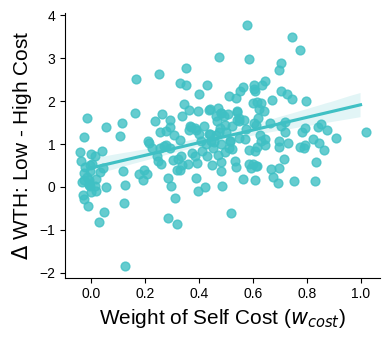

In [ ]:
plt.figure(figsize=(4,3.5))
sns.regplot(x = model_fit_m2['w_cost'], y = WTH_mot['Low-High_Cost'], color = '#3fc0c4', x_jitter=0.05, scatter_kws={'s':40})
plt.xlabel('Weight of Self Cost ($w_{cost}$)',size=15)
plt.ylabel('$\Delta$ WTH: Low - High Cost',size=15)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig(datapath+"output/Figures/Fig_3/Fig_3c.svg", dpi=300, format='svg', bbox_inches='tight')
plt.show()

## 3d: w_cost ~ (Low - high) cost WTH

<>:4: SyntaxWarning: invalid escape sequence '\D'
<>:4: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipython-input-400341244.py:4: SyntaxWarning: invalid escape sequence '\D'
  plt.ylabel('$\Delta$ WTH: High - Low Benefit',size=15)


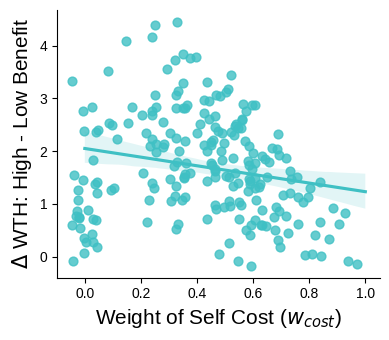

In [ ]:
plt.figure(figsize=(4,3.5))
sns.regplot(x = model_fit_m2['w_cost'], y = WTH_mot['High-Low_Benefit'], color = '#3fc0c4', x_jitter=0.05, scatter_kws={'s':40})
plt.xlabel('Weight of Self Cost ($w_{cost}$)',size=15)
plt.ylabel('$\Delta$ WTH: High - Low Benefit',size=15)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig(datapath+"output/Figures/Fig_3/Fig_3d.svg", dpi=300, format='svg', bbox_inches='tight')
plt.show()

## 3e: b ~ WTH

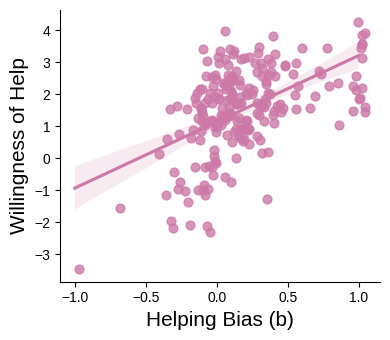

In [ ]:
plt.figure(figsize=(4,3.5))
sns.regplot(x = -model_fit_m2['b'], y = Task1_filtered['Mean'], color = '#cc79a7', x_jitter=0.05, scatter_kws={'s':40})
plt.xlabel('Helping Bias (b)',size=15)
plt.ylabel('Willingness of Help',size=15)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig(datapath+"output/Figures/Fig_3/Fig_3e.svg", dpi=300, format='svg', bbox_inches='tight')
plt.show()

## 3f: prediction performance

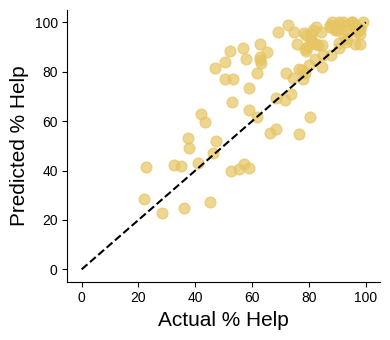

In [ ]:
scenario_pred = pred_allsub_df_m2.groupby('Scenario')[['Decision','Pred_choice']].mean()
scenario_pred = scenario_pred.merge(data_3spec, left_on='Scenario', right_index = True)

plt.figure(figsize=(4,3.5))
plt.plot([0,100],[0,100],color='black',ls='--')
plt.scatter(scenario_pred['Decision']*100,scenario_pred['Pred_choice']*100,alpha = 0.7,s=60, color= '#e6c563') # c=scenario_pred['label_numeric'],cmap="tab20")
plt.xlabel('Actual % Help',size=15)
plt.ylabel('Predicted % Help',size=15)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig(datapath+"output/Figures/Fig_3/Fig_3f.svg", dpi=300, format='svg', bbox_inches='tight')
plt.show()

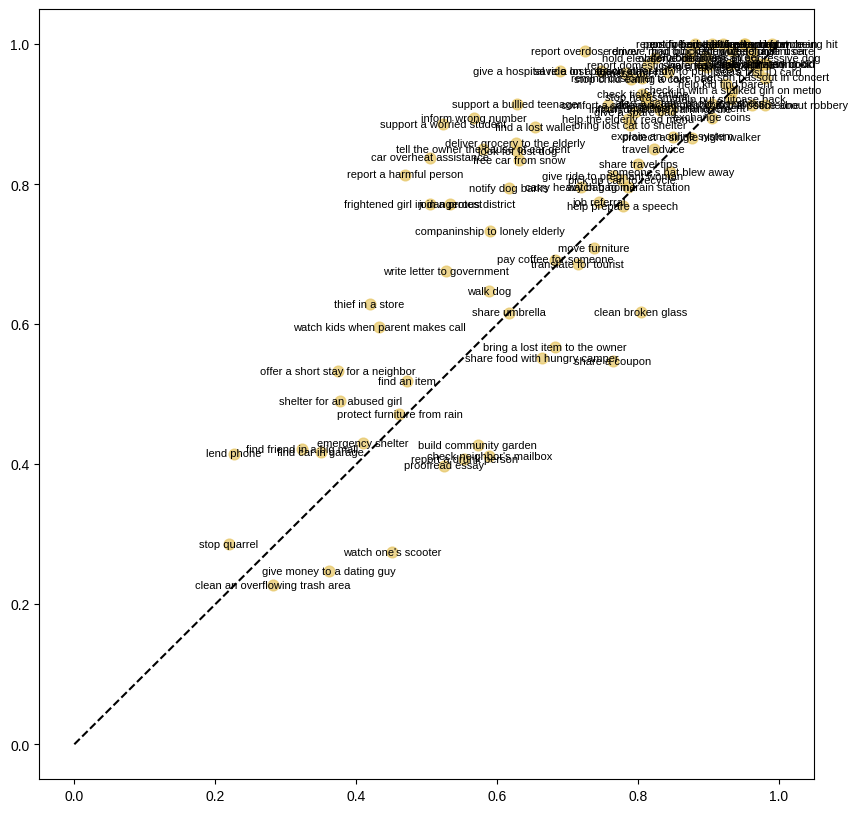

In [ ]:
plt.figure(figsize=(10,10))
plt.plot([0,1],[0,1],color='black',ls='--')
plt.scatter(scenario_pred['Decision'],scenario_pred['Pred_choice'],alpha = 0.7,s=60, color= '#e6c563') # c=scenario_pred['label_numeric'],cmap="tab20")
texts = [plt.text(sample['Decision'],sample['Pred_choice'],sample['Label'],ha='center',va='center',size=8) for row,sample in scenario_pred.iterrows()]
#adjust_text(texts,arrowprops=dict(arrowstyle='->', color='gray'))

plt.show()

# Supp Table 4: Model Comparison

In [ ]:
model_list = ['VBD_M1','VBD_M2','VBD_M3','VBD_M2_1','VBD_M2_2','VBD_M2_3','VBD_M2_4']
n_param = [2, 3, 4, 4, 4, 4, 4]
model_diagnostics = None
r2_all = extract_diagnostics(model_list,'r2',n_param)
AIC_all = extract_diagnostics(model_list,'AIC',n_param)
BIC_all = extract_diagnostics(model_list,'BIC',n_param)
LOOACC_all = extract_diagnostics(model_list,'test_acc',n_param)
model_diagnostics = pd.DataFrame({'R2':r2_all.iloc[:,1:].mean(axis=0),
                    'AIC':AIC_all.iloc[:,1:].mean(axis=0),
                    'BIC':BIC_all.iloc[:,1:].mean(axis=0),
                    'LOOACC':LOOACC_all.iloc[:,1:].mean(axis=0)})
model_diagnostics.round(4)


,R2,AIC,BIC,LOOACC
VBD_M1,0.2643,54.8430,58.6615,0.7426
VBD_M2,0.4194,46.1212,51.8488,0.7870
VBD_M3,0.4279,47.5361,55.1730,0.7855
VBD_M2_1,0.4214,47.9865,55.6234,0.7841
VBD_M2_2,0.4108,48.7183,56.3552,0.7823
VBD_M2_3,0.4194,48.1229,55.7598,0.7836
VBD_M2_4,0.4153,48.4069,56.0438,0.7855


# Supp Figure 4: Parameter recovery

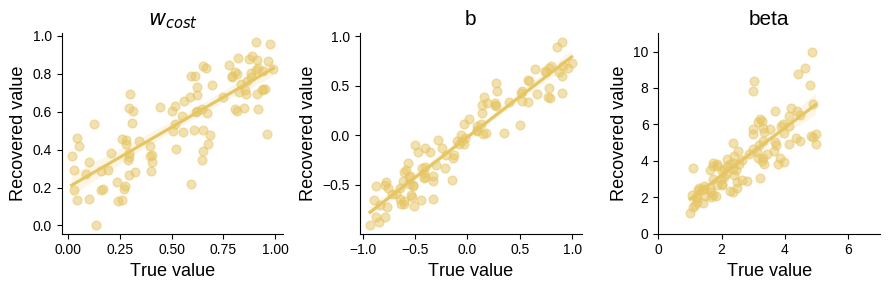

In [ ]:
param_names = ['w_cost','b','beta']
title_list = ['$w_{cost}$','b','beta']
fig,axes = plt.subplots(1,3,figsize=(9,3))
axes = axes.flatten()
for i,name in enumerate(param_names):
    sns.regplot(data = param_rec_df, x = f'{name}_original', y = f'{name}_recovered', color = '#e6c563', scatter_kws={'s':40,'alpha':0.5},ax=axes[i])
    #pearson_r = np.corrcoef(model_fit_m2[name],param_rec_df[name])[0,1]
    axes[i].set_xlabel('True value',size=13)
    axes[i].set_ylabel('Recovered value',size=13)
    axes[i].set_title(title_list[i],size=15)
    sns.despine()

axes[2].set_ylim([0,11])
axes[2].set_xlim([0,7])
plt.tight_layout()
plt.savefig(datapath+"output/Figures/Fig_S4/Fig_S4.svg", dpi=300, format='svg', bbox_inches='tight')
plt.show()


# Supp FIgure 5: Binarzied vs. Rating Model comparison

In [ ]:
model_fit_m2_continuous = pd.read_csv(datapath+'output/Model/VBD_M2_continuous/model_fits.csv')
pred_allsub_df_m2_conrinuous = pd.read_csv(datapath+'output/Model/VBD_M2_continuous/LOO_pred.csv')

## Compare Model Fit and Parameters

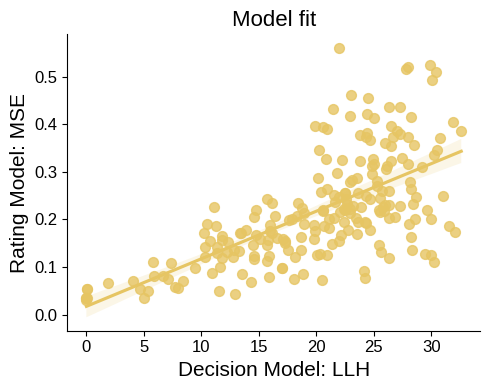

PearsonRResult(statistic=np.float64(0.6568267306650072), pvalue=np.float64(6.343950262596927e-28))

In [ ]:
# model fit
plt.figure(figsize=(5,4))
sns.regplot(x = model_fit_m2['neg_llh'], y = model_fit_m2_continuous['mse'], color = '#e6c563', x_jitter=0.05, scatter_kws={'s':50})

plt.xlabel('Decision Model: LLH',size=15)
plt.ylabel('Rating Model: MSE',size=15)
plt.title('Model fit',size=16)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)


plt.savefig(datapath+"output/Figures/Fig_S5/Fig_S5a.svg", format="svg",bbox_inches='tight')
plt.tight_layout()
plt.show()

r = pearsonr(model_fit_m2['neg_llh'],  model_fit_m2_continuous['mse'])
r

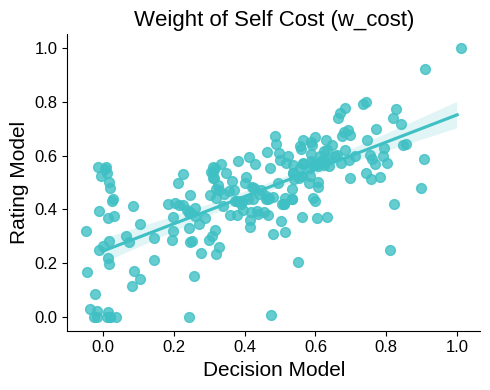

PearsonRResult(statistic=np.float64(0.7005468360630694), pvalue=np.float64(4.7472921056263505e-33))

In [ ]:
# w_cost
plt.figure(figsize=(5,4))
sns.regplot(x = model_fit_m2['w_cost'], y = model_fit_m2_continuous['w_cost'], color = '#3fc0c4', x_jitter=0.05, scatter_kws={'s':50})

plt.xlabel('Decision Model',size=15)
plt.ylabel('Rating Model',size=15)
plt.title('Weight of Self Cost (w_cost)',size=16)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)


plt.savefig(datapath+"output/Figures/Fig_S5/Fig_S5b.svg", format="svg",bbox_inches='tight')
plt.tight_layout()
plt.show()

r = pearsonr(model_fit_m2['w_cost'],  model_fit_m2_continuous['w_cost'])
r

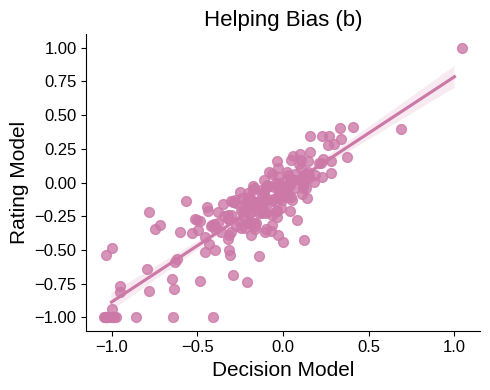

PearsonRResult(statistic=np.float64(0.8809009032873636), pvalue=np.float64(3.9441554033358775e-71))

In [ ]:
# b
plt.figure(figsize=(5,4))
sns.regplot(x = model_fit_m2['b'], y = model_fit_m2_continuous['b'], color = '#cc79a7', x_jitter=0.05, scatter_kws={'s':50})

plt.xlabel('Decision Model',size=15)
plt.ylabel('Rating Model',size=15)
plt.title('Helping Bias (b)',size=16)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)


plt.savefig(datapath+"output/Figures/Fig_S5/Fig_S5cd.svg", format="svg",bbox_inches='tight')
plt.tight_layout()
plt.show()

r = pearsonr(model_fit_m2['b'],  model_fit_m2_continuous['b'])
r

Posterior predictive check

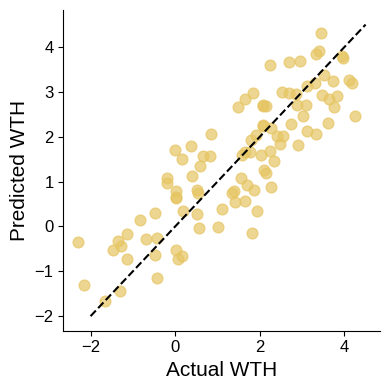

(np.float64(0.8537564844050834),
 np.float64(1.5689896077051205e-29),
 array([0.8055, 0.8922]))

In [ ]:
# check the prediction accuracy of scenarios
pred_allsub_df_m2_conrinuous['Pred_rating_transform'] = pred_allsub_df_m2_conrinuous['Pred_rating']*5
grouped_means = pred_allsub_df_m2_conrinuous.groupby('Scenario')[['WTH','Pred_rating_transform']].mean()


plt.figure(figsize=(4,4))
plt.scatter(grouped_means['WTH'],grouped_means['Pred_rating_transform'],alpha = 0.7,s=60, color= '#e6c563')
np.corrcoef(grouped_means['WTH'],grouped_means['Pred_rating_transform'])[0,1]
plt.plot([-2,4.5],[-2,4.5],color='black',ls='--')

plt.xlabel('Actual WTH',size=15)
plt.ylabel('Predicted WTH',size=15)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)


plt.savefig(datapath+"output/Figures/Fig_S5/Fig_S5d.svg", format="svg",bbox_inches='tight')
plt.tight_layout()
plt.show()

r_perc_pred,p_perc_pred = pearsonr(grouped_means['WTH'], grouped_means['Pred_rating_transform'])
ci_perc_pred = pg.compute_bootci(grouped_means['WTH'],grouped_means['Pred_rating_transform'], func='pearson', paired = True,
                       method='cper', n_boot=1000, confidence=0.95, decimals = 4)
r_perc_pred,p_perc_pred,ci_perc_pred

<>:4: SyntaxWarning: invalid escape sequence '\D'
<>:4: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipython-input-1142373353.py:4: SyntaxWarning: invalid escape sequence '\D'
  plt.ylabel('$\Delta$ WTH: Low - High Cost',size=15)


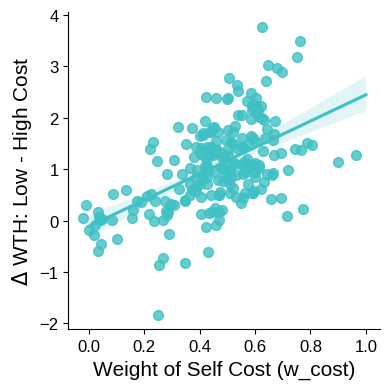

(np.float64(0.537544627811727),
 np.float64(1.6946453019960105e-17),
 array([0.4432, 0.6126]))

In [ ]:

plt.figure(figsize=(4,4))
sns.regplot(x = model_fit_m2_continuous['w_cost'], y = WTH_mot['Low-High_Cost'], color = '#3fc0c4', x_jitter=0.05, scatter_kws={'s':50})
plt.xlabel('Weight of Self Cost (w_cost)',size=15)
plt.ylabel('$\Delta$ WTH: Low - High Cost',size=15)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.savefig(datapath+"output/Figures/Fig_S5/Fig_S5e.svg", format="svg",bbox_inches='tight')
plt.tight_layout()
plt.show()

r_wcost_cost,p_wcost_cost = pearsonr(model_fit_m2_continuous['w_cost'],WTH_mot['Low-High_Cost'])
ci_wcost_cost = pg.compute_bootci(model_fit_m2_continuous['w_cost'],WTH_mot['Low-High_Cost'], func='pearson', paired = True,
                       method='cper', n_boot=1000, confidence=0.95, decimals = 4)
r_wcost_cost,p_wcost_cost,ci_wcost_cost

<>:4: SyntaxWarning: invalid escape sequence '\D'
<>:4: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipython-input-2334064305.py:4: SyntaxWarning: invalid escape sequence '\D'
  plt.ylabel('$\Delta$ WTH: High - Low Benefit',size=15)


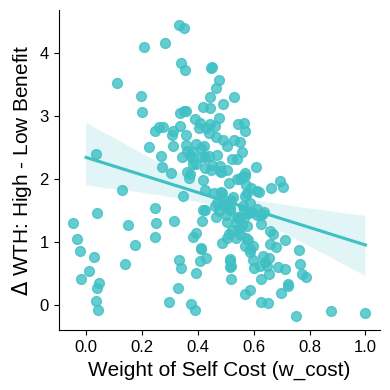

(np.float64(-0.24767287751599273),
 np.float64(0.00024470744915979674),
 array([-0.3892, -0.0613]))

In [ ]:
plt.figure(figsize=(4,4))
sns.regplot(x = model_fit_m2_continuous['w_cost'], y = WTH_mot['High-Low_Benefit'], color = '#3fc0c4', x_jitter=0.05, scatter_kws={'s':50})
plt.xlabel('Weight of Self Cost (w_cost)',size=15)
plt.ylabel('$\Delta$ WTH: High - Low Benefit',size=15)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.savefig(datapath+"output/Figures/Fig_S5/Fig_S5f.svg", format="svg",bbox_inches='tight')
plt.tight_layout()
plt.show()

r_wcost_highlowbenefit,p_wcost_highlowbenefit = pearsonr(model_fit_m2_continuous['w_cost'],WTH_mot['High-Low_Benefit'])
ci_wcost_highlowbenefit = pg.compute_bootci(model_fit_m2_continuous['w_cost'],WTH_mot['High-Low_Benefit'], func='pearson', paired = True,
                       method='cper', n_boot=1000, confidence=0.95, decimals = 4)
r_wcost_highlowbenefit,p_wcost_highlowbenefit,ci_wcost_highlowbenefit

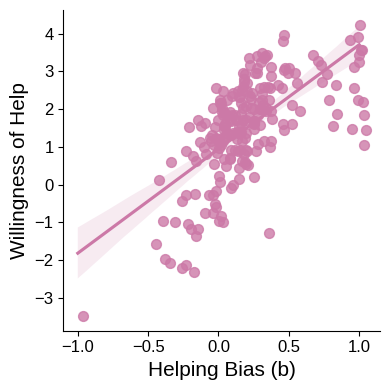

(np.float64(0.6636513673608785),
 np.float64(1.145532286886055e-28),
 array([0.5734, 0.7452]))

In [ ]:
plt.figure(figsize=(4,4))
sns.regplot(x = -model_fit_m2_continuous['b'], y = Task1_filtered['Mean'], color = '#cc79a7', x_jitter=0.05, scatter_kws={'s':50})
plt.xlabel('Helping Bias (b)',size=15)
plt.ylabel('Willingness of Help',size=15)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.savefig(datapath+"output/Figures/Fig_S5/Fig_S5g.svg", format="svg",bbox_inches='tight')
plt.tight_layout()
plt.show()

r_b_WTH,p_b_WTH = pearsonr(-model_fit_m2_continuous['b'], Task1_filtered['Mean'])
ci_b_WTH = pg.compute_bootci(-model_fit_m2_continuous['b'], Task1_filtered['Mean'], func='pearson', paired = True,
                       method='cper', n_boot=1000, confidence=0.95, decimals = 4)
r_b_WTH,p_b_WTH,ci_b_WTH

# Figure 4: Helping ~ Personality Traits

In [130]:
Survey1 = Task1_filtered.merge(trait_all,on='PROLIFIC_PID')
trait_merge = pd.read_csv(datapath+'data/Individual_differences_allvars.csv',index_col=0) # note that this trait_merge is different from the rest, which is created at the beginning

## 4a: WTH correlation with all questionnaires

In [127]:
Survey1 = pd.read_csv(datapath+'data/Task1_Final.csv')

In [128]:
# calculate pearson's correlation and the 95% CI of the r
rng = np.random.default_rng()
corr_r = []
corr_p = []
corr_error = []
for var in ['IRI_EC','SVO_degree','RR_total','BIS_total','BFI_A']:
    method_perm = stats.PermutationMethod(n_resamples=10000, random_state=rng)
    results = pearsonr(Survey1['Mean'], Survey1[var],method = method_perm)
    corr_r.append(results.statistic)
    corr_p.append(results.pvalue)
    ci = results.confidence_interval(method = stats.BootstrapMethod())
    corr_error.append((ci.high - ci.low)/2)

KeyError: 'IRI_EC'

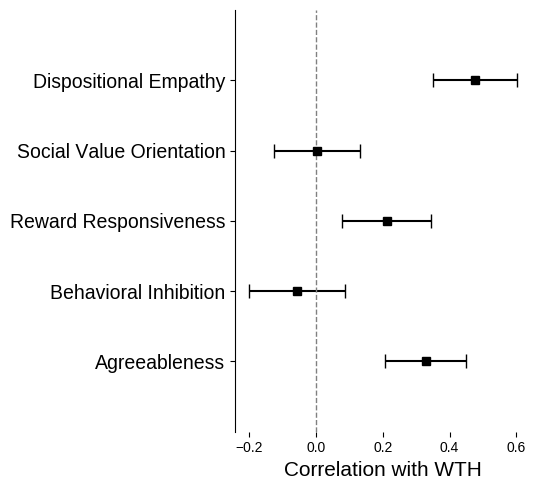

In [ ]:
## 6a: WTH ~ Traits
WTH_trait = Survey1[['Mean','IRI_EC','IRI_F','IRI_PD','IRI_PT','SVO_degree','RR_total','BIS_total','BFI_E','BFI_A','BFI_C','BFI_N','BFI_O']].corr()
WTH_trait_input = WTH_trait.loc[['Mean'],['IRI_EC','SVO_degree','RR_total','BIS_total','BFI_A']]

fig,ax = plt.subplots(figsize=(5.5,5))
plt.errorbar(corr_r, np.array([0,1,2,3,4]), xerr=corr_error, fmt='s', capsize=5,color='black')
ax.set_yticks([0,1,2,3,4])
ax.set_yticklabels(['Dispositional Empathy','Social Value Orientation','Reward Responsiveness','Behavioral Inhibition','Agreeableness'], size = 14)
ax.set_xlabel('Correlation with WTH',fontsize=15)
ax.set_ylim([-1,5])
# flip y axis
ax.invert_yaxis()
ax.spines['top'].set_visible(False)
ax.axvline(0,color='gray',lw=1,linestyle = '--')
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.tight_layout()
plt.savefig(datapath+"output/Figures/Fig_4/Fig_4a.svg", dpi=300, format='svg', bbox_inches='tight')
plt.show()

## 4b: w_cost ~ BIS

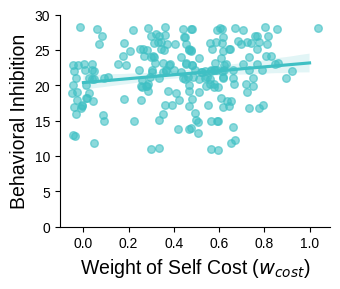

In [ ]:
plt.figure(figsize=(3.5,3))
sns.regplot(data = trait_merge, x = 'w_cost', y = 'BIS_total', y_jitter=0.2, x_jitter=0.05, color = '#3fc0c4', scatter_kws={'s':30,'alpha':0.6})
plt.xlabel('Weight of Self Cost ($w_{cost}$)',size=14)
plt.ylabel('Behavioral Inhibition',size=14)
plt.ylim([0,30])

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig(datapath+"output/Figures/Fig_4/Fig_4b.svg", dpi=300, format='svg', bbox_inches='tight')
plt.show()

## 4c: w_cost ~ RR

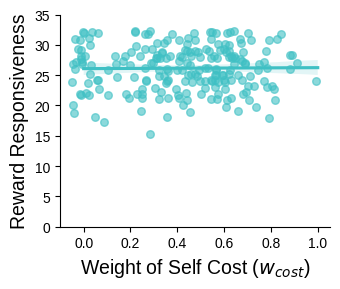

In [125]:
plt.figure(figsize=(3.5,3))
sns.regplot(data = trait_merge, x = 'w_cost', y = 'RR_total', y_jitter=0.3, x_jitter=0.05, color = '#3fc0c4', scatter_kws={'s':30,'alpha':0.6})
plt.xlabel('Weight of Self Cost ($w_{cost}$)',size=14)
plt.ylabel('Reward Responsiveness',size=14)
plt.ylim([0,35])
#plt.yticks([15,20,25,30,35])

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig(datapath+"output/Figures/Fig_4/Fig_4c.svg", dpi=300, format='svg', bbox_inches='tight')
plt.show()

## 4d: b ~ IRI_EC

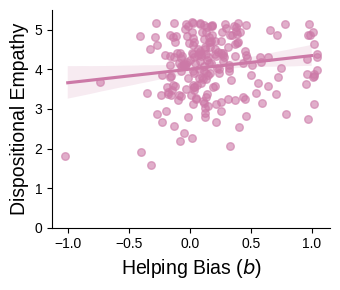

In [ ]:
trait_merge['b_flip'] = trait_merge['b']*(-1) # flip the b so the interpretation is more straightforward

plt.figure(figsize=(3.5,3))
sns.regplot(data = trait_merge, x = 'b_flip', y = 'IRI_EC', y_jitter=0.2, x_jitter=0.05, color = '#cc79a7', scatter_kws={'s':30,'alpha':0.6})
plt.xlabel('Helping Bias ($b$)',size=14)
plt.ylabel('Dispositional Empathy',size=14)
plt.ylim([0, 5.5])
#plt.yticks([1,2,3,4,5])

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig(datapath+"output/Figures/Fig_4/Fig_4d.svg", dpi=300, format='svg', bbox_inches='tight')
plt.show()

## 4e: b ~ BFI-A

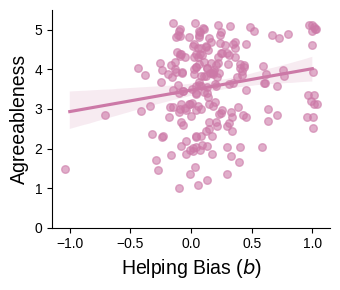

In [ ]:
plt.figure(figsize=(3.5,3))
sns.regplot(data = trait_merge, x = 'b_flip', y = 'BFI_A', y_jitter=0.2, x_jitter=0.05, color = '#cc79a7', scatter_kws={'s':30,'alpha':0.6})
plt.xlabel('Helping Bias ($b$)',size=14)
plt.ylabel('Agreeableness',size=14)
plt.ylim([0, 5.5])
#plt.yticks([1,2,3,4,5])

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig(datapath+"output/Figures/Fig_4/Fig_4e.svg", dpi=300, format='svg', bbox_inches='tight')
plt.show()

# Supp Figure 6: Demographic variables

/tmp/ipython-input-1449266823.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(['Male','Female'], size = 12)


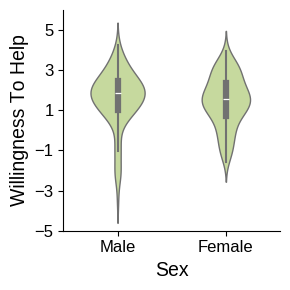

In [148]:
plt.figure(figsize=(3,3))
sns.violinplot(data=trait_merge, x="Sex", y="Mean", color = '#cae394',width=0.5, linewidth=1)
plt.ylabel('Willingness To Help',size=14)
plt.xlabel('Sex',size=14)
plt.yticks([-5,-3,-1,1,3,5],size=12)
plt.ylim(-5,6)
plt.gca().set_xticklabels(['Male','Female'], size = 12)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig(datapath+"output/Figures/Fig_S6/Fig_S6a.svg", dpi=300, format='svg', bbox_inches='tight')
plt.show()

/tmp/ipython-input-1153406324.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(['Man','Woman','Nonbinary'], size = 12)


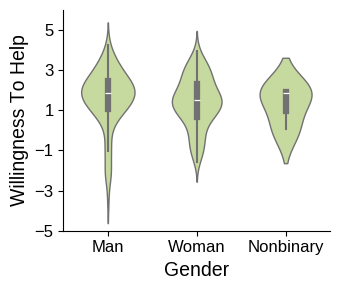

In [150]:
plt.figure(figsize=(3.5,3))
sns.violinplot(data=trait_merge.loc[trait_merge['Gender'].isin(['Male','Female','Non-binary / third gender'])], x="Gender", y="Mean", color = '#cae394',width=0.6, linewidth=1)
plt.ylabel('Willingness To Help',size=14)
plt.xlabel('Gender',size=14)
plt.yticks([-5,-3,-1,1,3,5],size=12)
plt.ylim(-5,6)
plt.gca().set_xticklabels(['Man','Woman','Nonbinary'], size = 12)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig(datapath+"output/Figures/Fig_S6/Fig_S6b.svg", dpi=300, format='svg', bbox_inches='tight')
plt.show()

/tmp/ipython-input-3678318728.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(['Non-Hispanic','Hispanic'],size = 12)


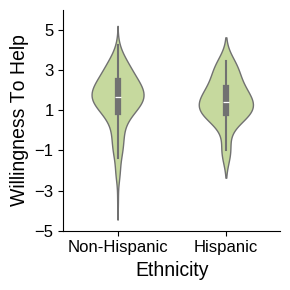

In [151]:
plt.figure(figsize=(3,3))
sns.violinplot(data=trait_merge, x="Ethnicity", y="Mean", color = '#cae394',width=0.5, linewidth=1)
plt.ylabel('Willingness To Help',size=14)
plt.xlabel('Ethnicity',size=14)
plt.yticks([-5,-3,-1,1,3,5],size=12)
plt.ylim(-5,6)
plt.gca().set_xticklabels(['Non-Hispanic','Hispanic'],size = 12)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig(datapath+"output/Figures/Fig_S6/Fig_S6c.svg", dpi=300, format='svg', bbox_inches='tight')
plt.show()

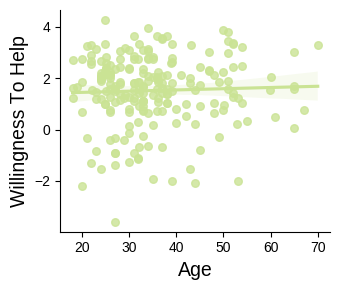

In [146]:
plt.figure(figsize=(3.5,3))
sns.regplot(data = trait_merge, x = 'Age', y = 'Mean', y_jitter=0.2, x_jitter=0.05, color = '#cae394', scatter_kws={'s':30,'alpha':0.8})
plt.xlabel('Age',size=14)
plt.ylabel('Willingness To Help',size=14)

sns.despine()

plt.tight_layout()
plt.savefig(datapath+"output/Figures/Fig_S6/Fig_S6d.svg", dpi=300, format='svg', bbox_inches='tight')
plt.show()

/tmp/ipython-input-2563238151.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(['Black','White','Asian','Multiracial','Native\n American'],rotation = 45, ha='right',size = 12)


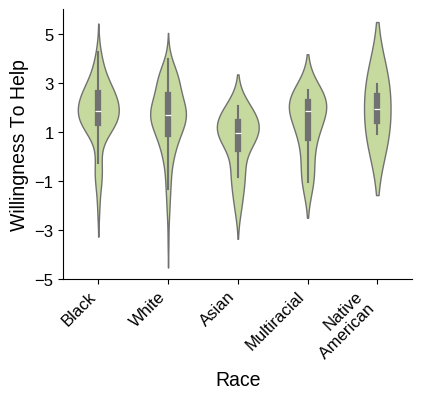

In [178]:
plt.figure(figsize=(4.5,3.5))
sns.violinplot(data=trait_merge.loc[trait_merge['Race_recode'].isin(['White or Caucasian','Black or African American','Asian','Multiracial','American Indian/Native American or Alaska Native'])], x="Race_recode", y="Mean", color = '#cae394',width=0.6, linewidth=1)
plt.ylabel('Willingness To Help',size=14)
plt.xlabel('Race',size=14)
plt.yticks([-5,-3,-1,1,3,5],size=12)
plt.ylim(-5,6)
plt.gca().set_xticklabels(['Black','White','Asian','Multiracial','Native\n American'],rotation = 45, ha='right',size = 12)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

#plt.tight_layout()
plt.savefig(datapath+"output/Figures/Fig_S6/Fig_S6e.svg", dpi=300, format='svg', bbox_inches='tight')
plt.show()

/tmp/ipython-input-455326979.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(['Some high\n school or less','High school \nor GED','Associates\n degree','Some\n college','Bachelor’s \ndegree','Graduate\n degree',],rotation = 45, ha='right',size = 12)


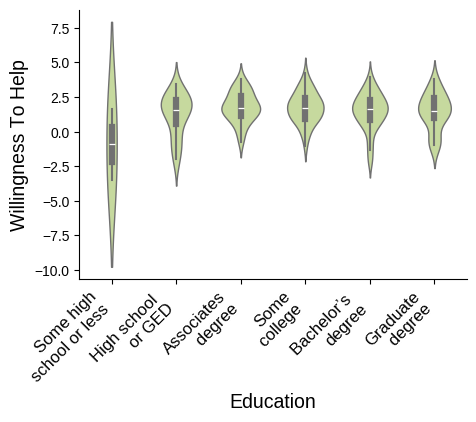

In [182]:
plt.figure(figsize=(5,3.5))
edu_order = ['Some high school or less', 'High school diploma or GED', 'Associates or technical degree', 'Some college, but no degree', 'Bachelor’s degree', 'Graduate or professional degree (MA, MS, MBA, PhD, JD, MD, DDS etc.)']
sns.violinplot(data=trait_merge.loc[~trait_merge['Education'].isin(['Prefer not to say'])], x="Education", y="Mean", order= edu_order,color = '#cae394',width=0.6, linewidth=1)
plt.ylabel('Willingness To Help',size=14)
plt.xlabel('Education',size=14)
plt.gca().set_xticklabels(['Some high\n school or less','High school \nor GED','Associates\n degree','Some\n college','Bachelor’s \ndegree','Graduate\n degree',],rotation = 45, ha='right',size = 12)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

#plt.tight_layout()
plt.savefig(datapath+"output/Figures/Fig_S6/Fig_S6f.svg", dpi=300, format='svg', bbox_inches='tight')
plt.show()

/tmp/ipython-input-1017653434.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(['$150K+','$100K-149K','$75K-99K','$50K-74K','$25K-49K','<$25K'],rotation = 45, ha='right',size = 12)


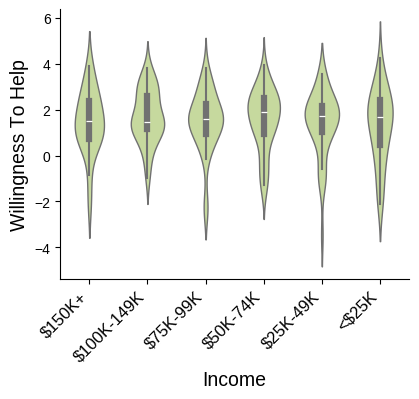

In [183]:
plt.figure(figsize=(4.5,3.5))
# Define the desired order of income levels
income_order = ['$150,000 or more', '$100,000-$149,999', '$75,000-$99,999', '$50,000-$74,999', '$25,000-$49,999', 'Less than $25,000']
sns.violinplot(data=trait_merge.loc[~trait_merge['Income'].isin(['Prefer not to say'])], x="Income", y="Mean", order=income_order, color = '#cae394',width=0.6, linewidth=1)
plt.ylabel('Willingness To Help',size=14)
plt.xlabel('Income',size=14)
plt.gca().set_xticklabels(['$150K+','$100K-149K','$75K-99K','$50K-74K','$25K-49K','<$25K'],rotation = 45, ha='right',size = 12)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

#plt.tight_layout()
plt.savefig(datapath+"output/Figures/Fig_S6/Fig_S6g.svg", dpi=300, format='svg', bbox_inches='tight')
plt.show()

# Figure 5: 3 space

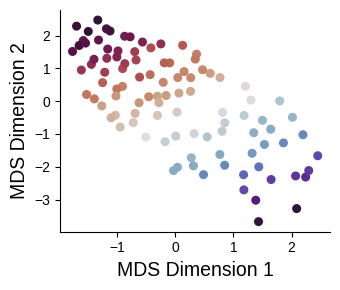

In [ ]:
fig, ax = plt.subplots(figsize=(3.5,3))
ax.scatter(data_3spec['Decision_x'],data_3spec['Decision_y'],c=data_3spec['WTH'],cmap="twilight_shifted",s=30)
ax.set_xlabel('MDS Dimension 1',size=14)
ax.set_ylabel('MDS Dimension 2',size=14)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig(datapath+"output/Figures/Fig_5/Fig_5b.svg", dpi=300, format='svg', bbox_inches='tight')
plt.show()

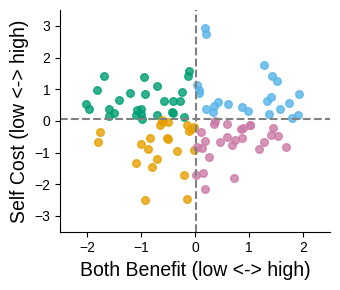

In [ ]:
med_reward = 0.0147062271753168
med_cost = 0.05109126821364465

col_list = ["#009e73", "#56b4e9", "#e69f00","#cc79a7"]
fig, ax = plt.subplots(figsize=(3.5,3))
for q in [1,2,3,4]:
    mask = data_3spec['Motivation_label'] == q
    ax.scatter(data_3spec['Motivation_reward'].loc[mask],data_3spec['Motivation_cost'].loc[mask],color=col_list[q-1],s=30,alpha=0.8)
ax.set_xlabel('Both Benefit (low <-> high)',size=14)
ax.set_ylabel('Self Cost (low <-> high)',size=14)
ax.axvline(med_reward,color='gray',ls='--') # median
ax.axhline(y=med_cost,color='gray',ls='--') # median
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xlim([-2.5,2.5])
ax.set_ylim([-3.5,3.5])

plt.tight_layout()
plt.savefig(datapath+"output/Figures/Fig_5/Fig_5d.svg", dpi=300, format='svg', bbox_inches='tight')
plt.show()

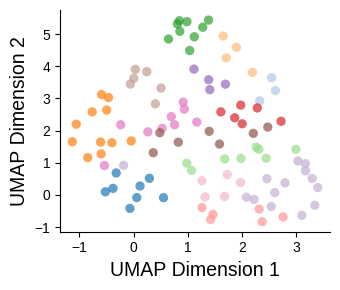

In [31]:
fig, ax = plt.subplots(figsize=(3.5,3))
data_3spec['Semantic_x_transform'] = data_3spec['Semantic_x']-3
data_3spec['Semantic_y_transform'] = data_3spec['Semantic_y']-3
sns.scatterplot(data=data_3spec,x = 'Semantic_x_transform', y = 'Semantic_y_transform',
                hue='label_numeric',palette="tab20",s=45, alpha=0.7,linewidth=0,legend=False)
ax.set_xlabel('UMAP Dimension 1',size=14)
ax.set_ylabel('UMAP Dimension 2',size=14)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


plt.tight_layout()
plt.savefig(datapath+"output/Figures/Fig_5/Fig_5f.svg", dpi=300, format='svg', bbox_inches='tight')
plt.show()

# Figure 6: Associations among three spaces

## 6a: Motivation space vs. Decision space

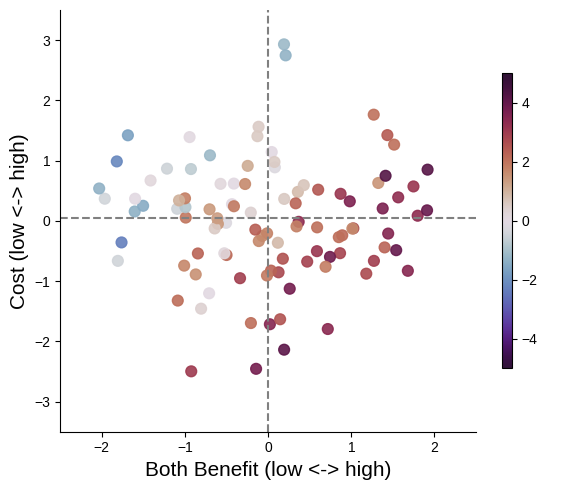

In [ ]:
# color the motivation space with WTH ratings
med_reward = data_3spec['Motivation_reward'].median()
med_cost = data_3spec['Motivation_cost'].median()

plt.figure(figsize=(6,5))
plt.axvline(x=med_reward,color='gray',ls='--')
plt.axhline(y=med_cost,color='gray',ls='--')
plt.scatter(data_3spec['Motivation_reward'],data_3spec['Motivation_cost'],c=data_3spec['WTH'],s =60, vmin=-5,vmax=5,cmap="twilight_shifted",alpha=0.9)
plt.xlabel('Both Benefit (low <-> high)',size=15)
plt.ylabel('Cost (low <-> high)',size=15)
plt.xlim([-2.5,2.5])
plt.ylim([-3.5,3.5])

# set the colors
norm = colors.Normalize(vmin=-5, vmax=5)
cmap = cm.twilight_shifted  # Choose the color map
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = plt.gca().figure.colorbar(sm, ax=plt.gca(),orientation='vertical', pad=0.05, aspect=30, shrink=0.7)
cbar.set_label(' ')


plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig(datapath+"output/Figures/Fig_6/Fig_6a.svg", dpi=300, format='svg', bbox_inches='tight')
plt.show()

## 6b: Decision space vs. Semantic space

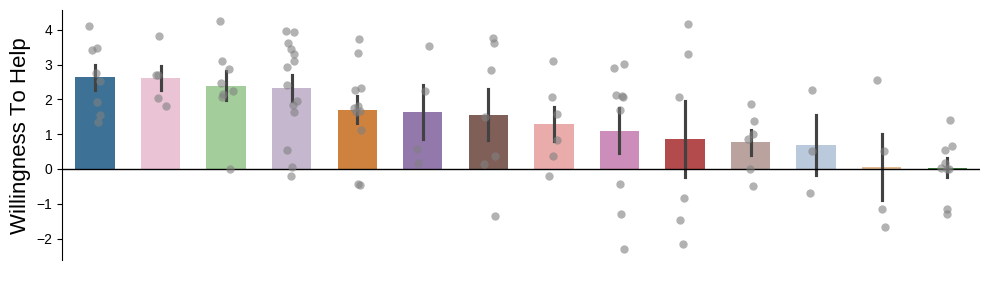

In [ ]:
# whether there are diff. in the overall ratings across different semantic categories
order = data_3spec.groupby('Semantic_label')['WTH'].mean().sort_values(ascending = False).index

# visualize the differences
fig,ax  = plt.subplots(figsize=(10,3))
sns.barplot(data=data_3spec, x="Semantic_label", y="WTH",hue = "label_numeric",errorbar = "se", order = order,
            palette = "tab20",width=0.6, saturation=0.6, linewidth=1, legend = False,ax=ax)
sns.stripplot(data=data_3spec, x='Semantic_label', y='WTH', order=order, color = 'gray',size=6,alpha=0.6,ax=ax)
ax.set_ylabel('Willingness To Help',size=16)
ax.set_xticks([])
ax.set_xlabel(' ')
ax.axhline(0,color='black',lw=1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.tight_layout()
plt.savefig(datapath+"output/Figures/Fig_6/Fig_6b.svg", dpi=300, format='svg', bbox_inches='tight')
plt.show()

In [ ]:
# print number of scenarios in each category
data_3spec.groupby('Semantic_label')['Scenario'].nunique()

,Scenario
Semantic_label,
(Heavy) Belongings,8
Act of God,3
Commercial Area,11
Community Issues,4
Community Welfare,9
Crime,8
For the Young Generation,6
Mobility Prosociality,6
Pet Care and Issues,4


## 6c: Motivation space vs. Semantic space

/tmp/ipython-input-2380100046.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(order, rotation=30, ha='right', size = 15)


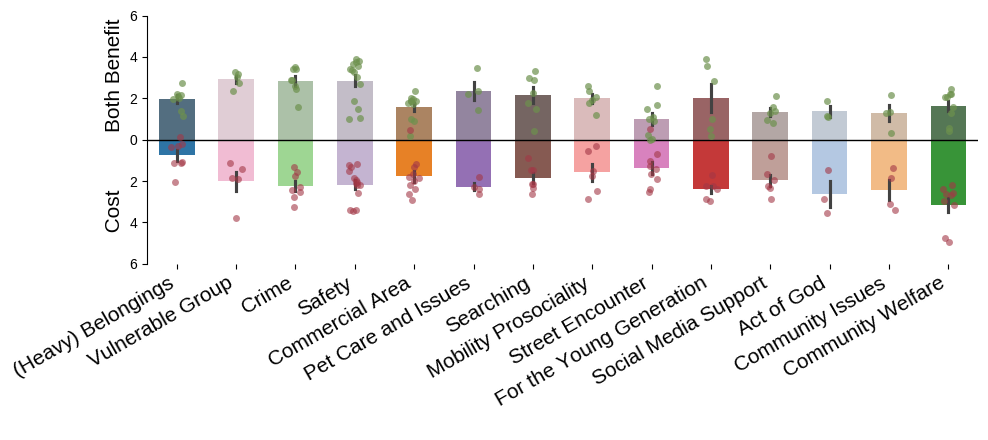

In [ ]:
# Benefit and Cost in the semantic space

data_3spec['Reward_transformed'] = data_3spec['Motivation_reward'] + 2
data_3spec['Cost_transformed'] = -(data_3spec['Motivation_cost'] + 2)

fig,ax = plt.subplots(figsize=(10,4.5))
sns.barplot(data=data_3spec, x="Semantic_label", y="Reward_transformed",hue = "label_numeric",errorbar = "se",order=order,
            palette = "tab20",width=0.6, saturation=0.3, linewidth=1, legend = False, ax = ax)
sns.stripplot(data=data_3spec, x="Semantic_label", y="Reward_transformed",order=order, color = '#6d914d',size=5,alpha=0.7,ax=ax)
ax.set_ylim([-6,6])
ax.set_ylabel('     Cost          Both Benefit',size = 15)
ax.set_xticklabels(order, rotation=30, ha='right', size = 15)
ax.set_xlabel(' ')
ax.set_yticks([-6, -4, -2, 0, 2, 4, 6])
ax.set_yticklabels([6, 4, 2, 0, 2, 4, 6])  # Reverse the labels
plt.axhline(0,color="black",lw=1)

sns.barplot(data=data_3spec, x="Semantic_label", y="Cost_transformed",hue = "label_numeric",errorbar = "se",order=order,
            palette = "tab20",width=0.6, saturation=0.8, linewidth=1, legend = False, ax = ax)
sns.stripplot(data=data_3spec, x="Semantic_label", y="Cost_transformed",order=order, color = '#a33746',size=5,alpha=0.6,ax=ax)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)


plt.tight_layout()
plt.savefig(datapath+"output/Figures/Fig_6/Fig_6c.svg", dpi=300, format='svg', bbox_inches='tight')
plt.show()

# Figure S7: 3 spaces association

## S7a

In [8]:
summary_4q = data_3spec.groupby('Motivation_label').agg(
    mean_value=('WTH', 'mean'),
    sample_size=('WTH', 'size'),
    std_dev=('WTH', 'std')
).reset_index()
summary_4q

,Motivation_label,mean_value,sample_size,std_dev
0,1,0.025540,27,1.150892
1,2,1.964774,23,1.680898
2,3,1.373986,23,1.331628
3,4,2.768993,27,0.796160


/tmp/ipython-input-1823068343.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=data_3spec, x="Motivation_label", y="WTH", palette = quadrant_cols,width=0.6, saturation=1, linewidth=1)
/tmp/ipython-input-1823068343.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(['Low Benefit \n High Cost','High Benefit \n High Cost','Low Benefit \n Low Cost','High Benefit \n High Cost'], rotation=45, ha='center', size = 12)


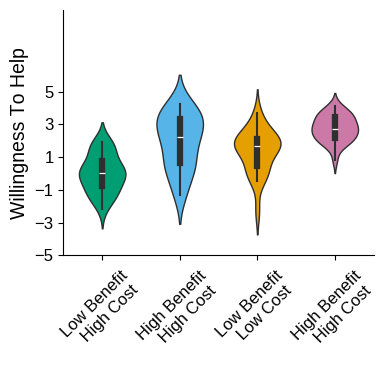

In [45]:
# Statistical analysis 1: comparison across 4 quadrants:
# customize colors
quadrant_cols = {'1':"#009e73",'2':"#56b4e9",'3':"#e69f00",'4':"#cc79a7"}
plt.figure(figsize=(4,4))
sns.violinplot(data=data_3spec, x="Motivation_label", y="WTH", palette = quadrant_cols,width=0.6, saturation=1, linewidth=1)
plt.ylabel('Willingness To Help',size=14)
plt.xlabel(' ',size=15)
plt.yticks([-5,-3,-1,1,3,5],size=12)
plt.ylim(-5,10)
plt.gca().set_xticklabels(['Low Benefit \n High Cost','High Benefit \n High Cost','Low Benefit \n Low Cost','High Benefit \n High Cost'], rotation=45, ha='center', size = 12)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig(datapath+"output/Figures/Fig_S7/Fig_S7a.svg", dpi=300, format='svg', bbox_inches='tight')
plt.show()

## S7bc: Cost and benefit ~ WTH

In [49]:
corr_WTH_benefit = stats.pearsonr(data_3spec['WTH'], data_3spec['Motivation_reward'])
ci_benefit = pg.compute_bootci(data_3spec['WTH'], data_3spec['Motivation_reward'], func='pearson', paired = True,
                       method='cper', n_boot=1000, confidence=0.95, decimals = 4)
corr_WTH_cost = stats.pearsonr(data_3spec['WTH'], data_3spec['Motivation_cost'])
ci_cost = pg.compute_bootci(data_3spec['WTH'], data_3spec['Motivation_cost'], func='pearson', paired = True,
                       method='cper', n_boot=1000, confidence=0.95, decimals = 4)

In [50]:
ci_benefit

array([0.6135, 0.7996])

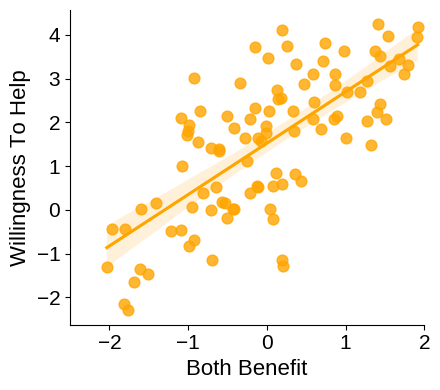

In [51]:
plt.figure(figsize=(4.5,4))

sns.regplot(x = data_3spec['Motivation_reward'], y = data_3spec['WTH'], color = 'orange', scatter_kws={'s':60})
plt.xlabel('Both Benefit',size=16)
plt.ylabel('Willingness To Help',size=16)
plt.xticks(size=15)
plt.yticks(size=15)
plt.xlim(-2.5,2)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig(datapath+"output/Figures/Fig_S7/Fig_S7b.svg", dpi=300, format='svg', bbox_inches='tight')
plt.show()

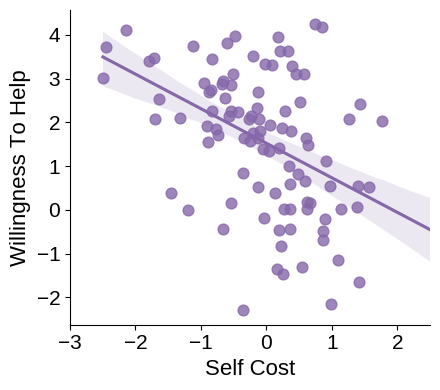

In [52]:
plt.figure(figsize=(4.5,4))
sns.regplot(x = data_3spec['Motivation_cost'], y = data_3spec['WTH'], color = '#8668aa', scatter_kws={'s':60})
plt.xlabel('Self Cost',size=16)
plt.ylabel('Willingness To Help',size=16)
plt.xticks(size=15)
plt.yticks(size=15)
plt.xlim(-3,2.5)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig(datapath+"output/Figures/Fig_S7/Fig_S7c.svg", dpi=300, format='svg', bbox_inches='tight')
plt.show()

## S7def: Semantic space

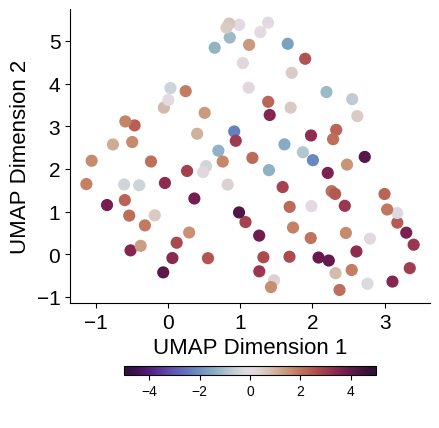

In [48]:
# S6d: color by WTH
fig, ax = plt.subplots(figsize=(4.5,4.5))
ax.scatter(data_3spec['Semantic_x_transform'],data_3spec['Semantic_y_transform'],c=data_3spec['WTH'],cmap="twilight_shifted",vmin=-5, vmax=5,s=60)
ax.set_xlabel('UMAP Dimension 1',size=16)
ax.set_ylabel('UMAP Dimension 2',size=16)
plt.xticks(size=15)
plt.yticks(size=15)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# set the colors
norm = colors.Normalize(vmin=-5, vmax=5)
cmap = cm.twilight_shifted  # Choose the color map
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = plt.gca().figure.colorbar(sm, ax=plt.gca(),orientation='horizontal', pad=0.15, aspect=30, shrink=0.7)
cbar.set_label(' ')

plt.tight_layout()
plt.savefig(datapath+"output/Figures/Fig_S7/Fig_S7d.svg", dpi=300, format='svg', bbox_inches='tight')
plt.show()

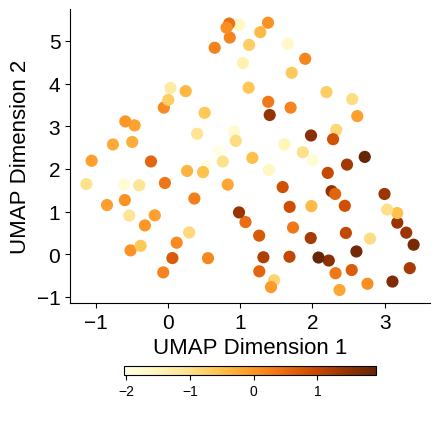

In [53]:
# S7e: color by benefit
fig, ax = plt.subplots(figsize=(4.5,4.5))
ax.scatter(data_3spec['Semantic_x_transform'],data_3spec['Semantic_y_transform'],c=data_3spec['Motivation_reward'],cmap="YlOrBr",s=60)
ax.set_xlabel('UMAP Dimension 1',size=16)
ax.set_ylabel('UMAP Dimension 2',size=16)
plt.xticks(size=15)
plt.yticks(size=15)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

norm = colors.Normalize(vmin=data_3spec['Motivation_reward'].min(), vmax=data_3spec['Motivation_reward'].max())
cmap = cm.YlOrBr  # Choose the color map
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = plt.gca().figure.colorbar(sm, ax=plt.gca(),orientation='horizontal', pad=0.15, aspect=30, shrink=0.7)
cbar.set_label(' ')


plt.tight_layout()
plt.savefig(datapath+"output/Figures/Fig_S7/Fig_S7e.svg", dpi=300, format='svg', bbox_inches='tight')
plt.show()

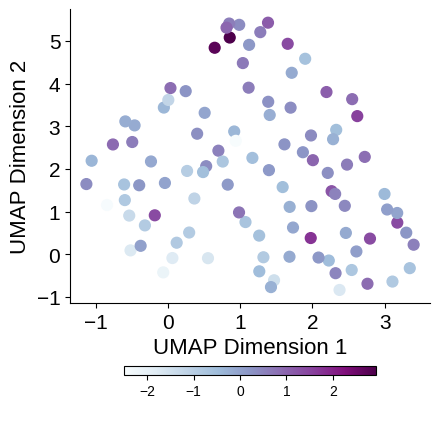

In [54]:
fig, ax = plt.subplots(figsize=(4.5,4.5))
ax.scatter(data_3spec['Semantic_x_transform'],data_3spec['Semantic_y_transform'],c=data_3spec['Motivation_cost'],cmap="BuPu",s=60)
ax.set_xlabel('UMAP Dimension 1',size=16)
ax.set_ylabel('UMAP Dimension 2',size=16)
plt.xticks(size=15)
plt.yticks(size=15)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

norm = colors.Normalize(vmin=data_3spec['Motivation_cost'].min(), vmax=data_3spec['Motivation_cost'].max())
cmap = cm.BuPu  # Choose the color map
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = plt.gca().figure.colorbar(sm, ax=plt.gca(),orientation='horizontal', pad=0.15, aspect=30, shrink=0.7)
cbar.set_label(' ')


plt.tight_layout()
plt.savefig(datapath+"output/Figures/Fig_S7/Fig_S7f.svg", dpi=300, format='svg', bbox_inches='tight')
plt.show()

# Figure 7

In [10]:
df_cohend = pd.read_csv(datapath+'output/cohend_personality.csv',index_col=0)
df_cohend = df_cohend[['b','w_cost','IRI_EC','BFI_A','RR_total','BIS_total','SVO_degree']]

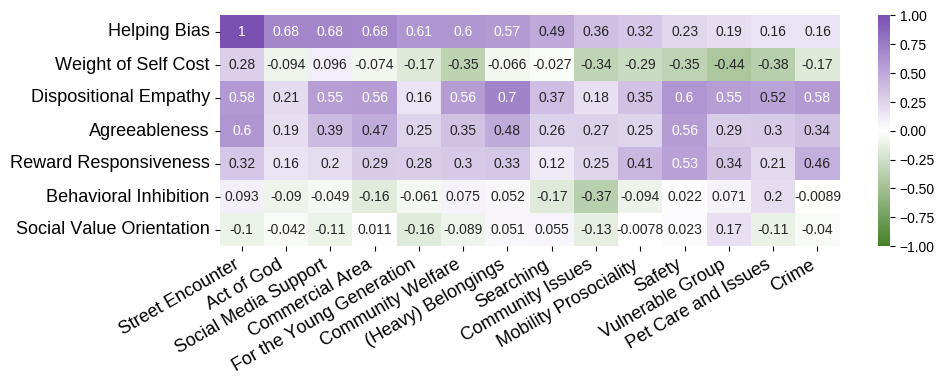

In [16]:
fig,ax = plt.subplots(figsize=(10,3))
#cmap = sns.diverging_palette(150, 12, as_cmap=True)
#cmap = sns.diverging_palette(h_neg=150, h_pos=12, s=99, l=50, sep=20, center='light', as_cmap=True) # Example with parameters
cmap = sns.color_palette("blend:#438025,#ffffff,#7b50b3", as_cmap=True)

sns.heatmap(df_cohend.T,vmin=-1,vmax=1,cmap=cmap,annot=True,ax=ax)
ax.set_ylabel('')
ax.set_yticklabels(['Helping Bias','Weight of Self Cost',
                    'Dispositional Empathy','Agreeableness','Reward Responsiveness', 'Behavioral Inhibition','Social Value Orientation'],size=13)
ax.set_xlabel('')
ax.set_xticklabels(df_cohend.index,rotation=30,ha='right',size=13)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.savefig(datapath+"output/Figures/Fig_7/Fig_7a.svg", dpi=300, format='svg', bbox_inches='tight')
plt.show()

# Stats

In [67]:
rng = np.random.default_rng()
method_perm = stats.PermutationMethod(n_resamples=10000, random_state=rng)
method_bs = stats.BootstrapMethod()

In [78]:
from scipy.stats import normaltest


In [69]:
# Figure 3c: w_cost ~ WTH low - high cost
results = pearsonr(model_fit_m2['w_cost'], WTH_mot['Low-High_Cost'],method = method_perm)
ci = results.confidence_interval(method = method_bs)
print(f"r = {results.statistic:.4f} , p = {results.pvalue:.4f}, 95% CI = ({ci[0]:.4f}, {ci[1]:.4f})")

r = 0.4286 , p = 0.0002, 95% CI = (0.3238, 0.5202)


In [ ]:
# Figure 3d: w_cost ~ WTH high - low benefit
results = pearsonr(model_fit_m2['w_cost'], WTH_mot['High-Low_Benefit'],method = method_perm)
ci = results.confidence_interval(method = method_bs)
print(f"r = {results.statistic:.4f} , p = {results.pvalue:.4f}, 95% CI = ({ci[0]:.4f}, {ci[1]:.4f})")

r = -0.2038 , p = 0.0020, 95% CI = (-0.3309, -0.0591)


In [ ]:
# Figure 3e: b ~ WTH
results = pearsonr(-model_fit_m2['b'], Task1_filtered['Mean'],method = method_perm)
ci = results.confidence_interval(method = method_bs)
print(f"r = {results.statistic:.4f} , p = {results.pvalue:.4f}, 95% CI = ({ci[0]:.4f}, {ci[1]:.4f})")

r = 0.5222 , p = 0.0002, 95% CI = (0.4205, 0.6238)


In [72]:
# Figure 4a: WTH ~ personalities
for var in ['IRI_EC','SVO_degree','RR_total','BIS_total','BFI_A']:
    results = pearsonr(trait_merge['Mean'], trait_merge[var],method = method_perm)
    ci = results.confidence_interval(method = method_bs)
    print(f"{var}: r = {results.statistic:.4f} , p = {results.pvalue*5:.4f}, 95% CI = ({ci[0]:.4f}, {ci[1]:.4f})")

IRI_EC: r = 0.4758 , p = 0.0010, 95% CI = (0.3471, 0.5985)
SVO_degree: r = 0.0030 , p = 4.7405, 95% CI = (-0.1230, 0.1283)
RR_total: r = 0.2115 , p = 0.0110, 95% CI = (0.0727, 0.3393)
BIS_total: r = -0.0576 , p = 2.0018, 95% CI = (-0.1911, 0.0965)
BFI_A: r = 0.3289 , p = 0.0010, 95% CI = (0.2075, 0.4464)


In [79]:
# Figure 4b: w_cost ~ BIS_total
results = pearsonr(trait_merge['w_cost'], trait_merge['BIS_total'],method = method_perm)
ci = results.confidence_interval(method = method_bs)
print(f"r = {results.statistic:.4f} , p = {results.pvalue:.4f}, 95% CI = ({ci[0]:.4f}, {ci[1]:.4f})")

r = 0.1551 , p = 0.0220, 95% CI = (0.0298, 0.2780)


In [80]:
# Figure 4c: w_cost ~ RR
results = pearsonr(trait_merge['w_cost'], trait_merge['RR_total'],method = method_perm)
ci = results.confidence_interval(method = method_bs)
print(f"r = {results.statistic:.4f} , p = {results.pvalue:.4f}, 95% CI = ({ci[0]:.4f}, {ci[1]:.4f})")

r = 0.0108 , p = 0.8671, 95% CI = (-0.1276, 0.1466)


In [81]:
# Figure 4d: b ~ IRI_EC
results = pearsonr(-trait_merge['b'], trait_merge['IRI_EC'],method = method_perm)
ci = results.confidence_interval(method = method_bs)
print(f"r = {results.statistic:.4f} , p = {results.pvalue:.4f}, 95% CI = ({ci[0]:.4f}, {ci[1]:.4f})")

r = 0.1597 , p = 0.0188, 95% CI = (0.0139, 0.3129)


In [82]:
# Figure 4e: b ~ agreeableness
results = pearsonr(-trait_merge['b'], trait_merge['BFI_A'],method = method_perm)
ci = results.confidence_interval(method = method_bs)
print(f"r = {results.statistic:.4f} , p = {results.pvalue:.4f}, 95% CI = ({ci[0]:.4f}, {ci[1]:.4f})")

r = 0.1862 , p = 0.0058, 95% CI = (0.0602, 0.3188)


In [83]:
# Figure 6: WTH ~ benefit
results = pearsonr(data_3spec['Motivation_reward'], data_3spec['WTH'],method = method_perm)
ci = results.confidence_interval(method = method_bs)
print(f"r = {results.statistic:.4f} , p = {results.pvalue:.4f}, 95% CI = ({ci[0]:.4f}, {ci[1]:.4f})")

r = 0.7227 , p = 0.0002, 95% CI = (0.6102, 0.8030)


In [84]:
# Figure 6: WTH ~ cost
results = pearsonr(data_3spec['Motivation_cost'], data_3spec['WTH'],method = method_perm)
ci = results.confidence_interval(method = method_bs)
print(f"r = {results.statistic:.4f} , p = {results.pvalue:.4f}, 95% CI = ({ci[0]:.4f}, {ci[1]:.4f})")

r = -0.4693 , p = 0.0002, 95% CI = (-0.6044, -0.2957)


In [ ]:
# Figure 6: one-way ANOVA - does not meet equal variance requirement -> welch's anova
stats.bartlett(data_3spec['WTH'][data_3spec['Motivation_label'] == 1],
             data_3spec['WTH'][data_3spec['Motivation_label'] == 2],
             data_3spec['WTH'][data_3spec['Motivation_label'] == 3],
             data_3spec['WTH'][data_3spec['Motivation_label'] == 4])

                         sum_sq    df          F        PR(>F)
C(Motivation_label)  107.461377   3.0  22.610153  3.708338e-11
Residual             152.089375  96.0        NaN           NaN
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     1      2   1.9392    0.0  1.0054  2.873   True
     1      3   1.3484 0.0016  0.4146 2.2823   True
     1      4   2.7435    0.0  1.8478 3.6391   True
     2      3  -0.5908 0.3882 -1.5612 0.3797  False
     2      4   0.8042 0.1169 -0.1296  1.738  False
     3      4    1.395  0.001  0.4612 2.3288   True
---------------------------------------------------


In [ ]:
results = pg.welch_anova(dv='WTH', between='Motivation_label', data=data_3spec)
print(results)
post_hoc = pg.pairwise_gameshowell(data=data_3spec, dv='WTH', between='Motivation_label')
print("\nGames-Howell Post-Hoc results:")
post_hoc

             Source  ddof1      ddof2         F         p-unc       np2
0  Motivation_label      3  49.488294  34.64781  3.277193e-12  0.414028

Games-Howell Post-Hoc results:


,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,1,2,0.025540,1.964774,-1.939234,0.414610,-4.677243,37.957673,2.054096e-04,-1.345526
1,1,3,0.025540,1.373986,-1.348446,0.355183,-3.796487,43.873979,2.437296e-03,-1.072962
2,1,4,0.025540,2.768993,-2.743453,0.269322,-10.186527,46.247775,1.270539e-12,-2.732242
3,2,3,1.964774,1.373986,0.590788,0.447148,1.321235,41.811153,5.549122e-01,0.382932
4,2,4,1.964774,2.768993,-0.804220,0.382519,-2.102429,30.276636,1.752440e-01,-0.618441
5,3,4,1.373986,2.768993,-1.395007,0.317134,-4.398799,34.714594,5.476365e-04,-1.277048


In [86]:
# Figure S6a: WTH ~ sex
from pingouin import ttest
stats.levene(trait_merge['Mean'][trait_merge['Sex']=='Male'], trait_merge['Mean'][trait_merge['Sex']=='Female'])
stat, p = normaltest(trait_merge['Mean'][trait_merge['Sex'] == 'Male'])
# did not meet normality assumption
ttest(trait_merge['Mean'][trait_merge['Sex']=='Male'], trait_merge['Mean'][trait_merge['Sex']=='Female']).round(3)
# print sample size for male and female
print(f"Male sample size: {len(trait_merge['Mean'][trait_merge['Sex']=='Male'])}")
print(f"Female sample size: {len(trait_merge['Mean'][trait_merge['Sex']=='Female'])}")

Male sample size: 105
Female sample size: 110


In [92]:
# Figure S6b: WTH ~ gender
stats.bartlett(trait_merge['Mean'][trait_merge['Gender'] == 'Male'],
               trait_merge['Mean'][trait_merge['Gender'] == 'Female'],
               trait_merge['Mean'][trait_merge['Gender'] == 'Non-binary / third gender'])
stat, p = normaltest(trait_merge['Mean'][trait_merge['Gender'] == 'Male'])
pg.welch_anova(dv='Mean', between='Gender', data=trait_merge[trait_merge['Gender'] != 'Prefer not to say'])

,Source,ddof1,ddof2,F,p-unc,np2
0,Gender,2,5.523774,0.399668,0.68848,0.004099


In [ ]:
# Figure S6c: Ethnicity
stats.levene(trait_merge['Mean'][trait_merge['Ethnicity']=='No'], trait_merge['Mean'][trait_merge['Ethnicity']=='Yes'])
# meet equal variance assumption
normaltest(trait_merge['Mean'][trait_merge['Ethnicity'] == 'No'])
# did not meet normality assumption
ttest(trait_merge['Mean'][trait_merge['Ethnicity']=='No'], trait_merge['Mean'][trait_merge['Ethnicity']=='Yes']).round(3)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.204,35.744,two-sided,0.84,"[-0.45, 0.55]",0.037,0.223,0.054


In [93]:
# print sample size
trait_merge['Ethnicity'].value_counts()

,count
Ethnicity,
No,189
Yes,26


In [ ]:
# Figure S6d: Age
results = pearsonr(trait_merge['Mean'], trait_merge['Age'],method = method_perm)
ci = results.confidence_interval(method = method_bs)
print(f"r = {results.statistic:.4f} , p = {results.pvalue:.4f}, 95% CI = ({ci[0]:.4f}, {ci[1]:.4f})")

r = 0.0382 , p = 0.5715, 95% CI = (-0.0974, 0.1665)


In [ ]:
# Figure S6e: Race
trait_merge['Race_recode'] = trait_merge['Race'].apply(lambda x: 'Multiracial' if ',' in str(x) else x)
pg.welch_anova(dv='Mean', between='Race_recode', data=trait_merge[trait_merge['Race_recode'].isin(['American Indian/Native American or Alaska Native',
 'Asian', 'Black or African American', 'Multiracial','White or Caucasian'])])

,Source,ddof1,ddof2,F,p-unc,np2
0,Race_recode,4,7.251965,2.601189,0.124508,0.05018


In [ ]:
# Figure S6f: Education level
set(trait_merge['Education'])
pg.welch_anova(dv='Mean', between='Education', data=trait_merge[trait_merge['Education']!='Prefer not to say'])

,Source,ddof1,ddof2,F,p-unc,np2
0,Education,5,10.650728,0.83137,0.554259,0.048794


In [ ]:
# Figure S6g: Income level
pg.welch_anova(dv='Mean', between='Income', data=trait_merge[trait_merge['Income']!='Prefer not to say'])

,Source,ddof1,ddof2,F,p-unc,np2
0,Income,5,83.951403,0.354184,0.878211,0.008671
